In [21]:
import numpy as np
import matplotlib.pyplot as plt
import lib.calc as c
import scipy.ndimage as nd
from skimage import filters, exposure, restoration, morphology, feature, measure
from ipywidgets import interact, fixed
from silx.io import specfile as spec
from matplotlib import patches
from lib.kmap import *

# %matplotlib inline

## Init

In [22]:
ls 

a1_area.npy                         learn_img_processing.ipynb
croi/                               old_shift_and_segment.ipynb
domain_fractions.ipynb              shift_and_segment.ipynb
kmap_img_analysis_background.ipynb  shift_and_segment_multi.ipynb
kmap_img_analysis_final.ipynb       watershed.ipynb
kmap_img_analysis.ipynb             wshed/


In [23]:
# initialise varables
sf = '/users/zatterin/Documents/beam/IHR_20171207_HC3313/e17089_fast_00022.spec'
rois_103 = ['roi1', 'roi3', 'roi2', 'roi4', 'roi5']
scan_list = [10,15,21,27,33,39,45,51,57,63,69,75,80,85,90]
voltages = [5,10,20,30,40,50,60,70,-10,-20,-30,-40,-50,-60,-70,100,150]


# select scans
# for i,scan in enumerate(scan_list):
#     scan_list[i] = scan - 1
# scan_list.append(94)
# scan_list.append(96)

print(scan_list) 

voltagesd = dict()
for i in range(len(scan_list)):
    voltagesd[scan_list[i]] = voltages[i]

# build kmaps dictionary and lists
kmaps_allrois = {} 
roi1, roi2, roi3, roi4, roi5 = [], [], [], [], []
for scan in scan_list:
    kmaps_allrois[scan] = read_kmap(sf, scan, rois_103, motors=False)
#     roi1.append(kmaps_allrois[scan]['roi1'])
#     roi2.append(kmaps_allrois[scan]['roi2'])
#     roi3.append(kmaps_allrois[scan]['roi3'])
#     roi4.append(kmaps_allrois[scan]['roi4'])
#     roi5.append(kmaps_allrois[scan]['roi5'])

[10, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 80, 85, 90]


In [38]:
denoise_kmap??

## Calc
No need to go back to the init to change roi.

In [24]:
# Denoise and make dict
kmaps_denoised = dict()
for scan_no in kmaps_allrois.keys():
    kmaps_denoised[scan_no] = dict()
    for roi in kmaps_allrois[scan_no].keys():
        kmaps_denoised[scan_no][roi] = denoise_kmap(kmaps_allrois[scan_no][roi])

In [25]:
# Plot denoised
@interact(i=scan_list)
def plot(i):
    fig, axes = plt.subplots(1,4,figsize=(14,3))
    for index, ax in enumerate(axes):
        roi = 'roi'+str(index+1)
        ax.imshow(kmaps_denoised[i][roi])
        ax.set_title('roi{0}...{1} V'.format(index+1,voltagesd[i]))

interactive(children=(Dropdown(description='i', options=(10, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 80, 8…

In [26]:
scan_list

[10, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 80, 85, 90]

In [27]:
kmaps_denoised.keys()

dict_keys([33, 69, 39, 63, 10, 75, 45, 15, 80, 51, 21, 57, 90, 27, 85])

In [28]:
def shift_kmaps_dict(denoised_kmaps, scan_list, roi_list, refroi='roi5'):

    # lists
#     scan_list = denoised_kmaps.keys()
#     roi_list = denoised_kmaps[scan_list[0]].keys()

    # init
    shift_list = dict()
    windows_idx = dict()
    shifted_kmaps = dict()
    for scan in scan_list:
        shifted_kmaps[scan] = dict()
    shifted_kmaps[scan_list[0]] = denoised_kmaps[scan_list[0]]

    ## Calc shifts and shift images
    for roi in roi_list:
        for index in range(1, len(scan_list)):
            # init
            shift_list[roi] = list()

            # make life simpler
            scan = scan_list[index]
            first_scan = scan_list[0]

            # ref kmaps to calc shift
            refimg = denoised_kmaps[first_scan][refroi]
            img = denoised_kmaps[scan][refroi]

            # calc of shift of two ref imgs
            shift, error, diffphase  = feature.register_translation(refimg,
                                       img)

            # shift imgs of interest by calculated amount
            shifted_kmaps[scan][roi] = nd.shift(denoised_kmaps[scan][roi],
                                        shift, order=0)

            # append shifts
            shift_list[roi].append(shift)

    ## Calc largest shift and largest window
    for roi in roi_list:
        shifts = np.array(shift_list[roi])

        # largest shift
        y_max = int(abs(shifts[:,0]).max())
        x_max = int(abs(shifts[:,1]).max())

        # largest window
        if shifts[:,0].max() > 0:
            winidx = np.s_[y_max:,x_max:]
        elif shifts[:,0].max() <= 0:
            winidx = np.s_[:denoised_kmaps[scan_list[0]][roi].shape[1]-y_max,x_max:]

        # assign
        windows_idx[roi] = winidx


    return shifted_kmaps, windows_idx

In [29]:
kmaps_shifted, winidx = shift_kmaps_dict(kmaps_denoised,scan_list,rois_103)

In [30]:
# Plot windowed
@interact(i=scan_list)
def plot(i):
    fig, axes = plt.subplots(1,4,figsize=(14,3))
    for index, ax in enumerate(axes):
        roi = 'roi'+str(index+1)
        ax.imshow(kmaps_shifted[i][roi])
        ax.set_title('roi{0}...{1} V'.format(index+1,voltagesd[i]))

interactive(children=(Dropdown(description='i', options=(10, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 80, 8…

In [31]:
# Plot denoised
@interact(i=scan_list)
def plot(i):
    fig, axes = plt.subplots(1,4,figsize=(14,3))
    for index, ax in enumerate(axes):
        roi = 'roi'+str(index+1)
        ax.imshow(kmaps_shifted[i][roi][winidx[roi]])
        ax.set_title('roi{0}...{1} V'.format(index+1,voltagesd[i]))

interactive(children=(Dropdown(description='i', options=(10, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 80, 8…

In [32]:
# Select only non-shifting window
for index, kmap in enumerate(roi_shifted):
    roi_shifted[index] = kmap[roi_winidx]
    
# plot it
@interact(i=(0, len(roi_shifted)-1))
def plot(i=0):
    plt.imshow(roi_shifted[i])
    plt.title('{0} V'.format(voltages[i]))
    plt.show()

NameError: name 'roi_shifted' is not defined

## Load something
If you want.

In [33]:
ls wshed

roi1_0v_mask.npy   roi2_shifted.npy  wshed_line_roi1.npy  wshed_line_roi4.npy
roi1_70v_mask.npy  roi3_shifted.npy  wshed_line_roi2.npy
roi1_shifted.npy   roi4_shifted.npy  wshed_line_roi3.npy


In [34]:
roi = np.load('wshed/roi1_shifted.npy')

## Watershed

In [35]:
# select an image
kmap = roi[0]

# compute rmax
h = kmap.max() - kmap.max()/5
hmax = morphology.reconstruction(kmap-h, kmap, method='dilation', 
                                 selem=morphology.selem.disk(1))
rmax = kmap - hmax

# close gaps in rmax
rmax_closed = morphology.closing(rmax, selem=morphology.selem.disk(1))

# calc inner (background) markers
# ots = filters.threshold_otsu(rmax_closed, nbins=int(rmax_closed.max()))
ots = filters.threshold_otsu(rmax_closed)
rmax_ts = rmax_closed > ots
innermarkers, nlabels = morphology.label(rmax_ts, neighbors=4, return_num=True)
innermarkers = morphology.erosion(innermarkers, selem=morphology.selem.disk(1))

# find inner and outer markers from watershed
wshed_bkg = morphology.watershed(-kmap, innermarkers, watershed_line=True)
lines = (wshed_bkg==0).astype('int8')
lines[wshed_bkg==0] = nlabels + 1
markers = innermarkers + lines # inner and outer

# final watershed on morphological gradient of kmap
mgrad = morphology.dilation(kmap,selem=morphology.selem.disk(1))\
      - morphology.erosion(kmap,selem=morphology.selem.disk(1))
wshed = morphology.watershed(mgrad, markers, watershed_line=True)
wshed_line = np.ma.masked_where(wshed!=0,wshed)

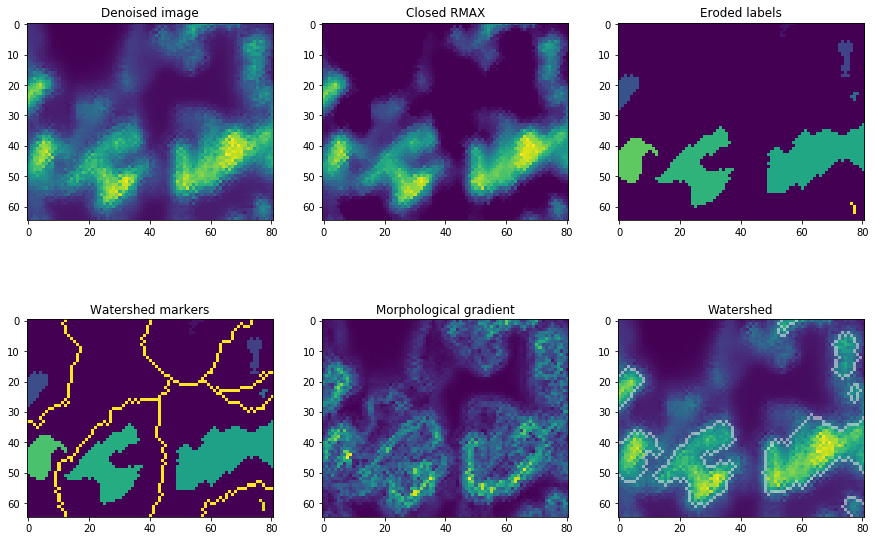

In [36]:
## Plot
fig, axes = plt.subplots(2,3, figsize=(15,10))
ax = axes.ravel()

ax[0].imshow(kmap) # denoised image
ax[0].set_title('Denoised image')
ax[1].imshow(rmax_closed) # closed regional max
ax[1].set_title('Closed RMAX')
ax[2].imshow(innermarkers) # eroded labels
ax[2].set_title('Eroded labels')
ax[3].imshow(markers) # inner and outer watershed markers
ax[3].set_title('Watershed markers')
ax[4].imshow(mgrad) # morpho gradient of original image
ax[4].set_title('Morphological gradient')
ax[5].imshow(kmap)
# ax[5].imshow(wshed==0,cmap='Reds',alpha=0.3) # final watershed
ax[5].imshow(wshed_line,cmap='Reds',alpha=0.5)
ax[5].set_title('Watershed');

## Observe what happens to segmented superdomains

### A1 Roi1/3:

In [57]:
@interact(i=(0, len(roi_shifted)-1))
def plot(i=0):
    fig, axes = plt.subplots(2,3,figsize=(15,8))
    ax = axes.ravel()

    ax[0].imshow(roi1_shifted[0])
    ax[0].imshow(wshed_line_roi1,cmap='Reds',alpha=0.5)
    ax[0].set_title('Initial segmentation')

    ax[1].imshow(roi1_shifted[i])
    ax[1].imshow(wshed_line_roi1,cmap='Reds',alpha=0.5)
    ax[1].set_title('{0} V - roi1'.format(voltages[i]))
    
    ax[2].imshow(roi1_shifted[i])
    ax[2].imshow(wshed_line_roi3,cmap='Reds',alpha=0.5)
    ax[2].set_title('{0} V - roi1 inverted'.format(voltages[i]))
    
    ax[3].imshow(roi3_shifted[0])
    ax[3].imshow(wshed_line_roi3,cmap='Reds',alpha=0.5)
    ax[3].set_title('Initial segmentation')

    ax[4].imshow(roi3_shifted[i])
    ax[4].imshow(wshed_line_roi3,cmap='Reds',alpha=0.5)
    ax[4].set_title('{0} V - roi3'.format(voltages[i]))

    ax[5].imshow(roi3_shifted[i])
    ax[5].imshow(wshed_line_roi1,cmap='Reds',alpha=0.5)
    ax[5].set_title('{0} V - roi3 inverted'.format(voltages[i]))

    plt.show()

### A2 Roi2/4

In [91]:
@interact(i=(0, len(roi_shifted)-1))
def plot(i=0):
    fig, axes = plt.subplots(2,3,figsize=(15,8))
    ax = axes.ravel()

    ax[0].imshow(roi2_shifted[0])
    ax[0].imshow(wshed_line_roi2,cmap='Reds',alpha=0.5)
    ax[0].set_title('Initial segmentation')

    ax[1].imshow(roi2_shifted[i])
    ax[1].imshow(wshed_line_roi2,cmap='Reds',alpha=0.5)
    ax[1].set_title('{0} V - roi2'.format(voltages[i]))
    
    ax[2].imshow(roi2_shifted[i])
    ax[2].imshow(wshed_line_roi4,cmap='Reds',alpha=0.5)
    ax[2].set_title('{0} V - roi2 inverted'.format(voltages[i]))
    
    ax[3].imshow(roi4_shifted[0])
    ax[3].imshow(wshed_line_roi4,cmap='Reds',alpha=0.5)
    ax[3].set_title('Initial segmentation')

    ax[4].imshow(roi4_shifted[i])
    ax[4].imshow(wshed_line_roi4,cmap='Reds',alpha=0.5)
    ax[4].set_title('{0} V - roi4'.format(voltages[i]))

    ax[5].imshow(roi4_shifted[i])
    ax[5].imshow(wshed_line_roi4,cmap='Reds',alpha=0.5)
    ax[5].set_title('{0} V - roi4 inverted'.format(voltages[i]))

    plt.show()

Back to [calc](#Calc)

## More stuff

In [17]:
roi = np.load('roi1_shifted.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'roi1_shifted.npy'

Make "markers" from conventional thresholding

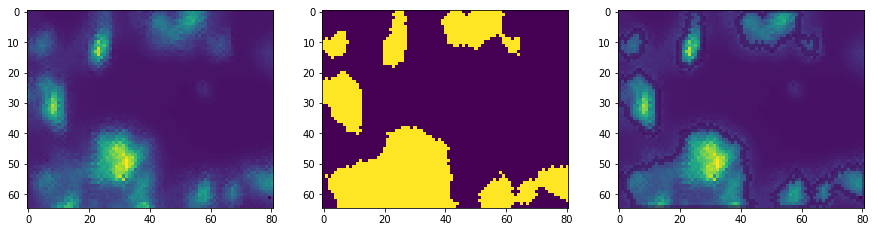

In [18]:
# select an image
kmap = roi[7]
se = morphology.selem.disk(1)

# compute rmax
h = kmap.max() - kmap.max()/20
hmax = morphology.reconstruction(kmap-h, kmap, method='dilation', 
                                 selem=morphology.selem.disk(1))
rmax = kmap - hmax

# close gaps in rmax
rmax_closed = morphology.closing(rmax, selem=morphology.selem.disk(1))

# totally arbitrary threshold!!
ots = filters.threshold_li(rmax_closed)
rmax_ts = rmax_closed > 0.15*rmax_closed.max()
rmax_tsm = morphology.binary_dilation(rmax_ts, selem=se) ^ morphology.binary_erosion(rmax_ts, selem=se)

# mask it
mask = np.ma.masked_where(rmax_tsm==0, rmax_tsm)

# plot
fig, ax = plt.subplots(1,3, figsize=(15,4))

ax[0].imshow(kmap)
ax[1].imshow(rmax_ts)
ax[2].imshow(kmap)
ax[2].imshow(mask, alpha=0.5)

In [74]:
np.save('roi1_70v_mask.npy', rmax_tsm)

Again but for the +70V image

## Mess around

(-0.5, 79.5, 319.5, -0.5)

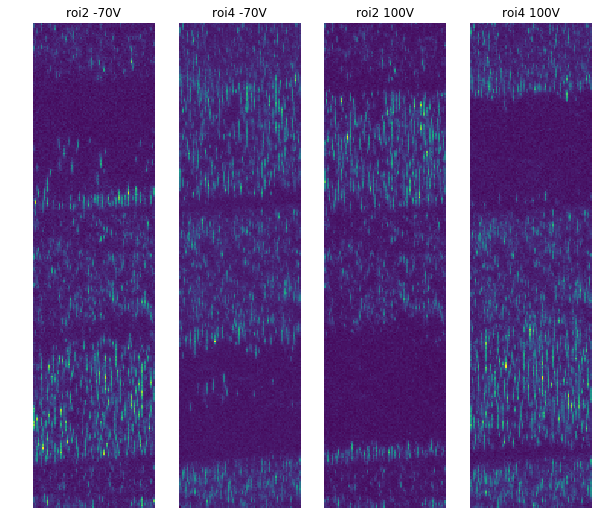

In [16]:
fig, axes = plt.subplots(1,4,figsize=(5*2,10*2))
ax = axes.ravel()

ax[0].imshow(roi2[14])
ax[0].set_title('roi2 {0}V'.format(voltages[14]))
ax[0].axis('off')

ax[1].imshow(roi4[14])
ax[1].set_title('roi4 {0}V'.format(voltages[14]))
ax[1].axis('off')

ax[2].imshow(roi2[15])
ax[2].set_title('roi2 {0}V'.format(voltages[15]))
ax[2].axis('off')

ax[3].imshow(roi4[15])
ax[3].set_title('roi4 {0}V'.format(voltages[15]))
ax[3].axis('off')

interactive(children=(Dropdown(description='i', options=(10, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 80, 85, 90), value=10), Output()), _dom_classes=('widget-interact',))

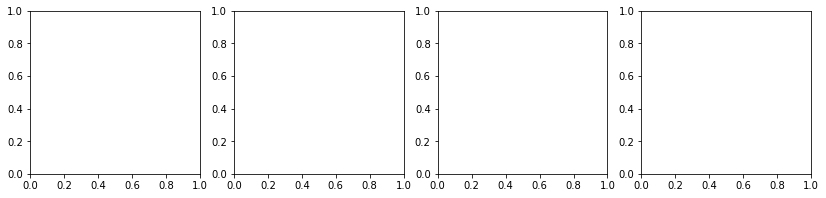

In [149]:
# Shift the denoised kmaps
roi_shifted, roi_winidx, roi_shifts = shift_kmaps(roi_denoised)

# Plot them
@interact(i=(0, len(roi_shifted)-1))
def plot(i=0):
    plt.imshow(roi_shifted[i])
    plt.title('{0} V'.format(voltages[i]))
    plt.show()